# Proxy

In [1]:
# import library
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import copy

Allostery:
<div>
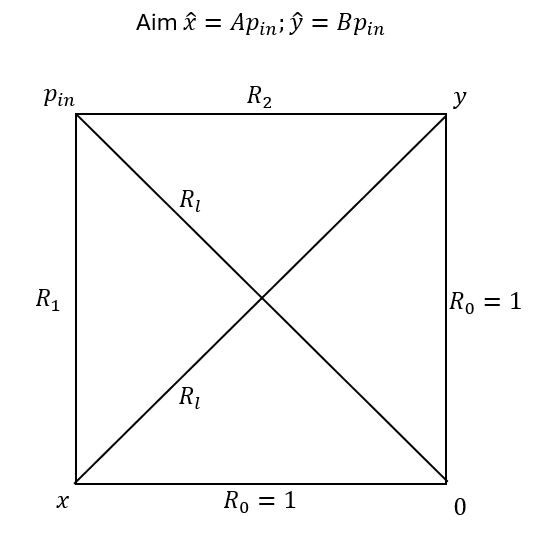
</div>


In [2]:
## Classes

class Variabs():
    def __init__(self, task_type, alpha, gamma):
        super(Variabs, self).__init__()
        self.task_type = task_type
        self.alpha = alpha
        self.gamma = gamma

class Syms():
    def __init__(self, variabs):
        super(Syms, self).__init__()
        if variabs.task_type == 'Allostery':
            self.x, self.y, self.R1, self.R2, self.Rl, self.p = sp.symbols('x, y, R1, R2, Rl, p')    
        elif variabs.task_type == 'Regression':
            self.x, self.R1, self.R2, self.Rl, self.p1, self.p2 = sp.symbols('x, R1, R2, Rl, p1, p2') 
        elif variabs.task_type == 'General_reg':
            self.x, self.y, self.z, self.R1, self.R2, self.R3, \
            self.R4, self.R5, self.R6, self.p1, self.p2 = sp.symbols('x, y, z, R1, R2, R3, R4, R5, R6, p1, p2') 

class State():
    def __init__(self, syms, variabs, supress_prints, bc_noise):
        super(State, self).__init__()
        self.syms = syms
        self.variabs = variabs
        
        # self.R_in_t = [np.array([2.59272486, 5.18544973])]
        self.out_in_t = []
        self.loss_in_t = []
        self.t = 0
        
        if self.variabs.task_type == 'Allostery':
            self.R_in_t = [np.array([1.,1.])]
            self.out_dual_in_t = [np.array([0.5,0.5])]
            self.p_in_t = [1]
            self.loss_fn = loss_fn_allostery
        elif self.variabs.task_type == 'Regression':
            self.R_in_t = [np.array([1.,1.])]
            self.out_dual_in_t = [np.array([0.5])]
            # self.p_in_t = [np.array([0.5, 1.5])]
            self.p_in_t = [np.array([1, 1])]
            self.p_drawn_in_t = []
            self.desired_in_t = []
            self.loss_fn = loss_fn_regression
        elif self.variabs.task_type == 'General_reg':
            # self.R_in_t = [np.array([1.,1.,1.,1.,1.,1.])]
            self.R_in_t = [np.array([18.7,2.4,4.0,-13.5,-12.8,1.5])]
            self.out_dual_in_t = [0.5*np.ones(3)]
            self.p_in_t = [1.0*np.ones(2)]
            self.p_drawn_in_t = []
            self.desired_in_t = []
            self.loss_fn = loss_fn_regression
            
        self.supress_prints = supress_prints
        self.bc_noise=bc_noise
        
    def assign_P(self, syms):
        if self.variabs.task_type == 'Allostery':
            self.P = (syms.p-syms.x)**2/syms.R1 + (syms.p-syms.y)**2/syms.R2 + syms.x**2 + syms.y**2 + \
                     syms.p**2/syms.Rl + (syms.x-syms.y)**2/syms.Rl 
        elif self.variabs.task_type == 'Regression':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + syms.p1**2 + syms.p2**2 + \
                     syms.x**2/syms.Rl + (syms.p1-syms.p2)**2/syms.Rl
        elif self.variabs.task_type == 'General_reg':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + (syms.p1-syms.y)**2/syms.R3 + \
                     (syms.p2-syms.y)**2/syms.R4 + (syms.p1-syms.z)**2/syms.R5 + (syms.p2-syms.z)**2/syms.R6 + \
                     syms.p1**2 + syms.p2**2 + syms.x**2 + syms.y**2 + syms.z**2 + (syms.p1-syms.p2)**2 + (syms.x-syms.y)**2 + \
                     (syms.y-syms.z)**2
            
    def solve_pressure(self, syms):        
        if self.variabs.task_type == 'Allostery':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            sols = sp.solve([dPdx,dPdy],[syms.x,syms.y])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
        elif self.variabs.task_type == 'Regression':
            dPdx = self.P.diff(syms.x)
            sols = sp.solve([dPdx],[syms.x])
            self.x = sols[syms.x]
        elif self.variabs.task_type == 'General_reg':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            dPdz = self.P.diff(syms.z)
            sols = sp.solve([dPdx,dPdy,dPdz],[syms.x,syms.y,syms.z])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
            self.z = sols[syms.z]
    
    def calc_output(self, syms):
        if self.variabs.task_type == 'Allostery':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            self.output = np.array([x_nxt, y_nxt])
        elif self.variabs.task_type == 'Regression':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p1:self.p_drawn[0],
                                 syms.p2:self.p_drawn[1], syms.Rl:2**(1/2)})
            self.output = x_nxt
        elif self.variabs.task_type == 'General_reg':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            z_nxt = self.z.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            self.output = np.array([x_nxt, y_nxt, z_nxt])
        if self.supress_prints:
            pass
        else:
            print('output=', self.output)
        self.out_in_t.append(self.output)
    
    def calc_loss(self, desired, output_prev=0, desired_prev=0):
        if self.variabs.task_type=='Allostery':
            self.loss = self.loss_fn(self.output, desired)
        elif self.variabs.task_type=='Regression' or self.variabs.task_type=='General_reg':
            self.loss = self.loss_fn(self.output, output_prev, desired, desired_prev)
        self.loss_in_t.append(self.loss)
        
    def update_pressure(self):
        self.t += 1
        loss = self.loss_in_t[-1]
        p = self.p_in_t[-1]
        pert = np.random.normal(size=np.size(p))
        if self.variabs.task_type == 'Allostery':     
            p_nxt = p - np.dot(self.variabs.alpha, loss+self.bc_noise*pert)
        elif self.variabs.task_type == 'Regression' or self.variabs.task_type=='General_reg':
            p_drawn = self.p_drawn_in_t[-1]
            p_drawn_prev = self.p_drawn_in_t[-2]
#             p_nxt = p - np.dot(self.variabs.alpha, np.dot(p_drawn-p_drawn_prev, loss[0]-loss[1]))
#             print('the dot for p', np.dot(self.variabs.alpha, np.dot(p_drawn-p_drawn_prev, loss[0]-loss[1])))
            p_nxt = p - (p_drawn-p_drawn_prev)*np.dot(self.variabs.alpha, loss[0]-loss[1])
            print('the dot for p', np.dot(self.variabs.alpha, loss[0]-loss[1]))
        if self.supress_prints:
            pass
        else:
            print('loss=', loss)
            print('time=', self.t)
            print('p_nxt=', p_nxt)
        self.p_in_t.append(p_nxt)
        
    def update_BCs(self, desired):
        loss = self.loss_in_t[-1]
        pert = np.random.normal(size=np.size(self.output))
        out_dual = self.out_dual_in_t[-1]
        if self.variabs.task_type=='Allostery':
            self.output = out_dual + self.variabs.alpha * (loss + self.bc_noise*pert)
        elif self.variabs.task_type=='Regression' or self.variabs.task_type=='General_reg':
#             print('output', self.output)
#             print('output_prev', self.out_in_t[-2])
            # self.output = out_dual + self.variabs.alpha * np.dot(self.output-self.out_in_t[-2], loss[0]-loss[1])
            self.output = out_dual + self.variabs.alpha * (self.output-self.out_in_t[-2])*(loss[0]-loss[1])
        self.out_dual_in_t.append(self.output)           
        if self.supress_prints:
            pass
        else:
            print('dual output', self.output)
    
    def update_Rs(self):
        if self.variabs.task_type=='Allostery' or self.variabs.task_type=='Regression':
            self.R_in_t.append(self.variabs.gamma * (self.p_in_t[-1]-self.output))
        else:
            R_ij = []
            print(self.p_in_t[-1])
            for i, p in enumerate(self.p_in_t[-1]):
                for j, out in enumerate(self.output):
                    R_ij.append(self.variabs.gamma[i*len(self.output)+j] * (p - out))
            # self.R_in_t.append(R_ij)
            self.R_in_t.append(self.R_in_t[0])
        if self.supress_prints:
            pass
        else:
            print('R_nxt', self.R_in_t[-1])
            
    def draw_p(self):
        self.p_drawn = np.random.uniform(low=0.0, high=2.0, size=2)
        self.p_drawn_in_t.append(self.p_drawn)
        # self.p_in_t[-1] = p_drawn
        # x=5
        
    def update_alpha(self, alpha):
        if self.variabs.task_type == 'Allostery':
            self.variabs.alpha = np.array([alpha, alpha])
        else:
            self.variabs.alpha = alpha
        # print('new alpha=', self.variabs.alpha)

In [3]:
## functions

def run_model_changing_alpha(alpha_vec, task_type, training, supress, bc_noise=0):
    if task_type=='Allostery':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec))
        print('alpha_vec', alpha_vec)
        gamma = np.array([1.0, 1.0])  # how much resistance changed due to pressure difference
        x_hat = 0.2
        y_hat = 0.3
        desired = np.array([x_hat, y_hat])
        A = copy.copy(x_hat)
        B = copy.copy(y_hat)
    elif task_type=='Regression':
        gamma = np.array([1.0])  # how much resistance changed due to pressure difference
        A = 0.4
        B = 0.25
        AB_vec = np.array([A, B])  # this is in terms of A & B, the calculated desired pressure is calculated in train loop
    elif task_type=='General_reg':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec, alpha_vec))
        print(alpha_vec)
        gamma = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])  # how much resistance changed due to pressure difference
        A = 0.05
        B = 0.25
        C = 0.1
        D = 0.15
        E = 0.02
        F = 0.3
        M = np.array([[A, B],  
                      [C, D], 
                      [E, F]])  # this is in terms of M matrix, desired press. is calculated in train loop
    
    for j, alpha in enumerate(alpha_vec):
#        print(alpha)
        ## classes for variables and symbols
        variabs = Variabs(task_type, alpha, gamma)
        syms = Syms(variabs)

        ## network state
        state = State(syms, variabs, supress_prints=supress, bc_noise=bc_noise)
        state.assign_P(syms)
        state.solve_pressure(syms)
        
        for i in range(training):
            if task_type=='Allostery':
                if np.size(alpha)>2:  # if alpha is annealed, change. In allostery alpha is 2D anyway
                    state.update_alpha(alpha[i])
                state.calc_output(syms)
                state.calc_loss(desired)
                state.update_pressure()
                state.update_BCs(desired)
                state.update_Rs()
            elif task_type=='Regression' or task_type=='General_reg':              
                if task_type=='Regression' and np.size(alpha)>1 :
                    state.update_alpha(alpha(i))
                state.draw_p()
                if task_type=='Regression':
                    desired = np.dot(AB_vec, state.p_drawn)
                else:
                    desired = np.matmul(M, state.p_drawn)
                state.desired_in_t.append(desired)
                if supress:
                    pass
                else:
                    print('p_drawn', state.p_drawn)
                    print('desired', desired)
                state.calc_output(syms)
                if not i % 2:  # even iterations
                    pass
                else:
                    state.calc_loss(desired, state.out_in_t[-2], state.desired_in_t[-2])
                    state.update_pressure()
                    state.update_BCs(desired)
                    state.update_Rs()              
                       
        # print(state.p_in_t)
        plot_importants(state, variabs, desired, A, B)
    return state, variabs, desired


def plot_importants(state, variabs, desired, A=1, B=1):
    if variabs.task_type == 'Allostery':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
        Rl_subs = 2**(1/2)
        R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        legend1 = ['x', 'y', 'x desired', 'y deisred']
        legend2 = ['x dual', 'y dual', 'p dual']
        legend3 = ['R1', 'R2', 'R1 theoretical', 'R2 theoretical']
    elif variabs.task_type == 'Regression':
        Rl_subs = 2**(1/2)
        R_theor = np.array([Rl_subs*(1-A-B)/A, Rl_subs*(1-A-B)/B])
        legend1 = ['x', 'x desired']
        legend2 = ['x dual', 'p1 dual', 'p2 dual']
        legend3 = ['R1', 'R2', 'R1 theoretical', 'R2 theoretical']
    elif task_type=='General_reg':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
#         C = desired[2]/state.p_in_t[0]  # B = y_hat/p_in
#         D = desired[3]/state.p_in_t[0]  # B = y_hat/p_in
#         E = desired[4]/state.p_in_t[0]  # B = y_hat/p_in
#         F = desired[5]/state.p_in_t[0]  # B = y_hat/p_in
        # R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        legend1 = ['x', 'y', 'z', 'x desired', 'y deisred', 'z desired']
        legend2 = ['x dual', 'y dual', 'z dual', 'p1 dual', 'p2 dual']
        legend3 = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6']
        R_theor = []  # I didn't calculate it for this task
    legend4 = ['|loss|']
    print('R theoretical', R_theor)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4.5))
    if variabs.task_type=='Allostery':
        ax1.plot(state.out_in_t[1:], '.')
        ax1.plot(np.outer(desired,np.ones(state.t)).T, '--')
    elif variabs.task_type=='Regression' or task_type=='General_reg':  # regression goes only every two samples
        ax1.plot(np.linspace(0, state.t, 2*state.t-1).T, state.out_in_t[1:])
        ax1.plot(np.linspace(0, state.t, 2*state.t).T, state.desired_in_t, '--')
    ax1.set_title('output in time')
    ax1.set_xlabel('t')
    ax1.legend(legend1)
    ax2.plot(state.out_dual_in_t[1:])
    ax2.plot(state.p_in_t[1:])
    ax2.set_title('dual and p in time')
    ax2.set_xlabel('t')
    ax2.legend(legend2)
    ax3.plot(state.R_in_t[1:])
    ax3.plot(np.outer(R_theor,np.ones(state.t)).T, '--')
    ax3.set_title('R in time')
    ax3.set_xlabel('t')
    ax3.legend(legend3)
    # ax4.plot(np.abs(state.loss_in_t[1:]))
    ax4.plot(np.mean(np.mean(np.abs(state.loss_in_t[1:]), axis=1),axis=1))
    ax4.set_xlabel('t')
    ax4.legend(legend4)
    fig.suptitle(f'alpha={variabs.alpha}')
    plt.show()
    # print(state.R_in_t)

def loss_fn_allostery(output, desired):
    # return np.sign(desired-output)
    # return np.e**(-(desired-output)
    return desired-output
    # return np.sign(desired-output) * np.e**(-np.abs((desired-output)))
    
def loss_fn_regression(output1, output2, desired1, desired2):
    L1 = desired1-output1
    L2 = desired2-output2
    return np.array([L1, L2])

In [13]:
## Parameters

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
alpha_vec = np.array([1.0])
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])

# task - allostery or regression by now
# task_type = 'Regression'
# task_type = 'Allostery'
task_type = 'General_reg'

# training length
if np.size(alpha_vec[0])>1:  # if alpha is annealed
    training=len(alpha_vec[0])
else:
    training=800

[[1. 1. 1.]]
p_drawn [1.4303739  0.92402837]
desired [0.30252579 0.28164165 0.30581599]
output= [0.300704115360983 0.281279641712091 0.303472262082908]
p_drawn [1.40482714 0.54955112]
desired [0.20762914 0.22291538 0.19296188]
output= [0.213550042669647 0.223394977599287 0.185436564085828]
the dot for p -0.00340258850456493
loss= [[-0.00592090493086478 -0.000479595179011860 0.00752531561385061]
 [0.00182167254876608 0.000362004073944933 0.00234372738582789]]
time= 1
p_nxt= [0.999913074885024 0.998725808019021]
dual output [0.500674797160478 0.500048715690075 0.499388387616772]
[0.999913074885024 0.998725808019021]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [1.07255667 1.08546378]
desired [0.32499378 0.27007523 0.34709027]
output= [0.315172270487418 0.268887904156476 0.351061351628548]
p_drawn [1.23446652 1.60137083]
desired [0.46206603 0.36365228 0.50510058]
output= [0.443179474189946 0.361464399892334 0.514808116009840]
the dot for p 0.00432914544758495
loss= [[0.018886560313

R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [1.59991137 1.43731211]
desired [0.4393236  0.37558795 0.46319186]
output= [0.428589787010427 0.374241088132883 0.466461908420771]
p_drawn [0.80149024 1.12446176]
desired [0.32118995 0.24881829 0.35336833]
output= [0.307102201869973 0.247200057411955 0.360907772296554]
the dot for p -0.000644083869174250
loss= [[0.0140877506554439 0.00161823114591858 -0.00753943900469545]
 [0.0107338091011909 0.00134686547467106 -0.00327004791002061]]
time= 21
p_nxt= [1.05632242558706 0.899574849360810]
dual output [0.542586557483956 0.501704067685851 0.447889069255648]
[1.05632242558706 0.899574849360810]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [1.92560434 0.53563311]
desired [0.23018849 0.2729054  0.19920202]
output= [0.242991833772742 0.274070525135232 0.185711294934662]
p_drawn [0.94337824 1.70287247]
desired [0.47288703 0.3497687  0.52972931]
output= [0.448134946581051 0.346978992057352 0.544138771263080]
the dot for p 0.0136100630549

output= [0.357070007156367 0.348662777989096 0.341705598399166]
the dot for p -0.00784024760583327
loss= [[-0.00231045164435006 -2.69353858969312e-5 0.00641723433183206]
 [0.0270899421069523 0.00294527166238859 -0.0181151188619225]]
time= 39
p_nxt= [1.14282677360700 0.705703752906158]
dual output [0.631151956778054 0.506004289260857 0.346398270583162]
[1.14282677360700 0.705703752906158]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [0.72357762 1.9444183 ]
desired [0.52228346 0.36402051 0.59779704]
output= [0.489550658730417 0.360391657777406 0.618163130578503]
p_drawn [0.77301181 1.96086413]
desired [0.52886662 0.3714308  0.60371948]
output= [0.496404468876371 0.367825575539899 0.623778555661410]
the dot for p 1.27433640558783e-5
loss= [[0.0324621542754562 0.00360522489201698 -0.0200590801882572]
 [0.0327327963052921 0.00362884864751872 -0.0203660893376507]]
time= 40
p_nxt= [1.14282614364915 0.705703543330896]
dual output [0.631150101848964 0.506004113643802 0.346399994570040]
[

output= [0.0273774957974020 0.0259721260202553 0.0271674757822391]
p_drawn [1.74840044 0.56859708]
desired [0.22956929 0.26012961 0.20554713]
output= [0.239422780697702 0.260995612013565 0.194498142571932]
the dot for p -5.05920608823568e-5
loss= [[-0.00985348941451297 -0.000866006579259615 0.0110489894453856]
 [5.50309570898008e-5 2.16424986741980e-5 0.000303412056731341]]
time= 59
p_nxt= [1.15821351485266 0.608685950765760]
dual output [0.669375043070882 0.508034529220631 0.306640746807071]
[1.15821351485266 0.608685950765760]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [0.40550604 1.0221146 ]
desired [0.27580395 0.19386779 0.3147445 ]
output= [0.258915279811423 0.191991765070408 0.325172025912538]
p_drawn [0.2964523  1.12724146]
desired [0.29663298 0.19873145 0.34410148]
output= [0.276101636010401 0.196473409299516 0.357269651124041]
the dot for p 0.00128403813465852
loss= [[0.0205313431006557 0.00225803899766922 -0.0131681680939451]
 [0.0168886720958344 0.00187602916274371 

the dot for p -0.00227061064663728
loss= [[0.00859651678272683 0.00108480885071199 -0.00248578292011697]
 [0.0199087387151615 0.00219558007626555 -0.0126381654314679]]
time= 89
p_nxt= [1.15960005721063 0.459924235920747]
dual output [0.736571016537085 0.512378574658995 0.242854651958662]
[1.15960005721063 0.459924235920747]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [0.11577419 0.49864329]
desired [0.13044953 0.08637391 0.15190847]
output= [0.121173149055028 0.0853557866890615 0.157903500041084]
p_drawn [1.04436647 1.57347642]
desired [0.44558743 0.34045811 0.49293025]
output= [0.424898775976447 0.338096920703437 0.504334191043843]
the dot for p 0.00734642322736953
loss= [[0.0206886514748444 0.00236118866618490 -0.0114039369016343]
 [0.00927638314932587 0.00101812575856887 -0.00599502889586920]]
time= 90
p_nxt= [1.15277822529784 0.452028056889439]
dual output [0.740037214888849 0.512718021901318 0.240980840220655]
[1.15277822529784 0.452028056889439]
R_nxt [ 18.7   2.4   4.  -

output= [0.0824536827834798 0.0901699508592580 0.0666172394348697]
p_drawn [0.59102017 1.59025615]
desired [0.42711505 0.29764044 0.48889725]
output= [0.400334656880793 0.294671604075066 0.505562239423124]
the dot for p 0.0129961332630571
loss= [[0.0267803899137448 0.00296883598083431 -0.0166649901149236]
 [-0.00348095702286803 -0.000307180652407271 0.00387624019187377]]
time= 106
p_nxt= [1.21280315846361 0.352041381069929]
dual output [0.782632432247959 0.514365849785529 0.188113373203420]
[1.21280315846361 0.352041381069929]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [0.34675625 0.73704886]
desired [0.20160003 0.14523295 0.22804978]
output= [0.190108498340135 0.143948294922715 0.234967771903342]
p_drawn [0.99937905 0.0075506 ]
desired [0.0518566  0.1010705  0.02225276]
output= [0.0643262159693277 0.102306111999661 0.0113049598532976]
the dot for p -0.00861562589986456
loss= [[-0.0124696127864715 -0.00123561683741533 0.0109478021075404]
 [0.0114915287866643 0.0012846590742644

R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [0.95955223 0.66320557]
desired [0.213779   0.19543606 0.21815272]
output= [0.211623706270769 0.195092124473259 0.217212711509350]
p_drawn [1.29229719 1.78744329]
desired [0.51147568 0.39734621 0.56207893]
output= [0.489312477757316 0.394796758197728 0.573861691985242]
the dot for p 0.00949066062843892
loss= [[0.0221632041539560 0.00254945404536244 -0.0117827611753311]
 [0.00215529795106051 0.000343933991382189 0.000940004453105769]]
time= 122
p_nxt= [1.24993891043839 0.170112379141218]
dual output [0.871603362696806 0.519739020975479 0.0969160005812411]
[1.24993891043839 0.170112379141218]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [0.80257388 1.57461824]
desired [0.43378325 0.31645012 0.48843695]
output= [0.410013730498702 0.313783061005073 0.502532945869578]
p_drawn [1.57705662 0.20862177]
desired [0.13100827 0.18899893 0.09412766]
output= [0.146449110696175 0.190489870421189 0.0797219167525213]
the dot for p -0.0148666216

output= [0.308014034686457 0.231252644847043 0.383205014206283]
p_drawn [1.55603236 1.16039695]
desired [0.36790086 0.32966278 0.37923973]
output= [0.362576610677050 0.328906916784754 0.378954632024446]
the dot for p -0.00330068343664228
loss= [[0.00532424497620632 0.000755862126148199 0.000285100177205011]
 [0.0192206015225456 0.00214287737683946 -0.0116975881831832]]
time= 138
p_nxt= [1.29484326021850 0.0776677479991743]
dual output [0.907336636635156 0.521084529315288 0.0533761092662391]
[1.29484326021850 0.0776677479991743]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [0.99076218 0.78766381]
desired [0.24645406 0.21722579 0.25611439]
output= [0.242012677979392 0.216630638385747 0.256645105068978]
p_drawn [0.53473967 1.85456319]
desired [0.49037778 0.33165845 0.56706375]
output= [0.457193355803432 0.328002419289120 0.588208164143351]
the dot for p 0.0111902230509039
loss= [[0.0331844250598612 0.00365602634311685 -0.0211444140298347]
 [0.00444138286363840 0.000595150710438197 

output= [0.431140597861146 0.332745215982399 0.524872214483653]
p_drawn [0.3678006  0.78530557]
desired [0.21471642 0.15457589 0.24294768]
output= [0.202451542131559 0.153205045366060 0.250336966126915]
the dot for p -0.00648297274762039
loss= [[0.0122648793727876 0.00137084952867306 -0.00738928431719857]
 [0.0241416601026741 0.00271742663679070 -0.0141296694075823]]
time= 159
p_nxt= [1.33484819773298 -0.125673790174541]
dual output [1.00280399197750 0.526723219760022 -0.0448124706364464]
[1.33484819773298 -0.125673790174541]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [1.52192689 0.03606052]
desired [0.08511147 0.15760177 0.04125669]
output= [0.103572090740334 0.159426152179476 0.0249429870735153]
p_drawn [0.82754771 1.23845508]
desired [0.35099116 0.26852303 0.38808748]
output= [0.334777586035806 0.266671538572295 0.397001951953456]
the dot for p 0.0131218863782264
loss= [[0.0162135700285955 0.00185149504908172 -0.00891447323773709]
 [-0.0184606161573606 -0.00182438531002824 

output= [0.345035792789621 0.289935962169473 0.389962121112090]
the dot for p 0.00585957173020490
loss= [[0.0121040899704120 0.00143788217097296 -0.00544564161972222]
 [-0.00244275606702574 -0.000119859710166398 0.00479937456864998]]
time= 207
p_nxt= [1.41855849045986 -0.342583331811308]
dual output [1.09487341571632 0.531066052932745 -0.149600362004491]
[1.41855849045986 -0.342583331811308]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [1.00290243 0.80533033]
desired [0.2514777  0.22108979 0.26165715]
output= [0.246809274256391 0.220468651190483 0.262311322729591]
p_drawn [1.78749319 1.74293874]
desired [0.52510934 0.44019013 0.55863148]
output= [0.510163998438751 0.438365482642602 0.564285579649061]
the dot for p 0.00648049728613911
loss= [[0.0149453447975757 0.00182464626263390 -0.00565409517314974]
 [0.00466843072038278 0.000621141761226240 -0.000654173880688280]]
time= 208
p_nxt= [1.41347395218767 -0.348659500513442]
dual output [1.09757988958857 0.531328292750240 -0.1511102

output= [0.413130200398901 0.354559135795837 0.457503292000132]
the dot for p 0.00906476442109882
loss= [[0.0122335617759020 0.00149095630599971 -0.00468496870291468]
 [-0.000650827673526937 -5.92673363763695e-5 0.000684879967791534]]
time= 223
p_nxt= [1.45332811426845 -0.421345344954873]
dual output [1.12541374743500 0.532281991348978 -0.186057772488970]
[1.45332811426845 -0.421345344954873]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [1.19753024 0.35899579]
desired [0.14962546 0.17360239 0.13164934]
output= [0.157030294550306 0.174266590292424 0.123637209724052]
p_drawn [0.96682118 1.97775208]
desired [0.54277908 0.39334493 0.61266205]
output= [0.512402958450932 0.389943344705833 0.630823079223742]
the dot for p 0.0156735715108118
loss= [[0.0303761196337518 0.00340158453925027 -0.0181610326045630]
 [-0.00740483470334205 -0.000664197927456867 0.00801213268842609]]
time= 224
p_nxt= [1.45694414918777 -0.446717037339469]
dual output [1.13884006582248 0.533158886115548 -0.19933243

output= [0.146144281041013 0.106158752739256 0.186355672328847]
the dot for p 0.00872168463249588
loss= [[0.0102074589121548 0.00112781232664765 -0.00643388215304808]
 [-0.0196277188311845 -0.00192203288332829 0.0177294561677712]]
time= 237
p_nxt= [1.51514427612500 -0.579970732895547]
dual output [1.20114980733214 0.536278096415201 -0.270070231535417]
[1.51514427612500 -0.579970732895547]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [0.60104797 1.79187602]
desired [0.4780214  0.3288862  0.54958377]
output= [0.447025277313182 0.325459570848211 0.569079775825075]
p_drawn [0.1205959  1.81803636]
desired [0.46053888 0.28476504 0.54782282]
output= [0.422906360754884 0.280674891584475 0.573016688585080]
the dot for p 0.00160206638365296
loss= [[0.0376325232902733 0.00409015192633522 -0.0251938637787285]
 [0.0309961262246234 0.00342662925576609 -0.0194960104261623]]
time= 238
p_nxt= [1.51591399223525 -0.580012643490474]
dual output [1.20098974462506 0.536248380765215 -0.270092663486986

output= [0.499428407941124 0.415804094296202 0.569380886911171]
the dot for p 3.49804348590554e-5
loss= [[0.0187010899916679 0.00220186006969375 -0.00884163545251881]
 [0.0217916086079893 0.00247648878206563 -0.0122417632160712]]
time= 252
p_nxt= [1.53272498597625 -0.664103833016125]
dual output [1.24086116110875 0.538614293595790 -0.311091186827513]
[1.53272498597625 -0.664103833016125]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [0.84732438 0.67730058]
desired [0.21169136 0.18632752 0.22013666]
output= [0.207813917902860 0.185809972838571 0.220644111588200]
p_drawn [1.06316475 0.25003888]
desired [0.11566796 0.14382231 0.09627496]
output= [0.123721115274471 0.144572200204193 0.0881596942358176]
the dot for p -0.00457533255718034
loss= [[-0.00805315723277904 -0.000749892756161108 0.00811526534391692]
 [0.00387744601566486 0.000517551809018690 -0.000507449912526436]]
time= 253
p_nxt= [1.53371252747615 -0.666058697376743]
dual output [1.24186443897296 0.538666560186595 -0.312233

R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [0.96004768 1.52070808]
desired [0.4281794  0.32411098 0.47541338]
output= [0.407561480820977 0.321767160810551 0.486980310494660]
p_drawn [0.31063707 1.48303429]
desired [0.38629043 0.25351885 0.45112303]
output= [0.358275314055662 0.250448554005723 0.469325866437924]
the dot for p 0.00148775944507840
loss= [[0.0280151122115992 0.00307029657926888 -0.0182028376741448]
 [0.0206179239635755 0.00234381966271568 -0.0115669319546462]]
time= 272
p_nxt= [1.52940548123717 -0.754170808710604]
dual output [1.27785931238281 0.540951912495739 -0.345668753158068]
[1.52940548123717 -0.754170808710604]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [1.10793    1.10935498]
desired [0.33273524 0.27719625 0.35496509]
output= [0.322846288674695 0.275997537633935 0.358893388817828]
p_drawn [1.82245449 0.51814266]
desired [0.22065839 0.25996685 0.19189189]
output= [0.232534615548007 0.261043426536268 0.179287285373512]
the dot for p -0.0075075719004

output= [0.254969053145624 0.192573761140076 0.315752047229100]
the dot for p -0.00613424272438093
loss= [[0.0155605867309403 0.00173810948040140 -0.00939881463124559]
 [0.0248457321243392 0.00283775350443227 -0.0136493613242944]]
time= 320
p_nxt= [1.62911007879637 -1.06594065378147]
dual output [1.41826370146486 0.548346531535071 -0.498990634019465]
[1.62911007879637 -1.06594065378147]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [1.59874864 0.85923753]
desired [0.29474681 0.28876049 0.28974623]
output= [0.296448877366358 0.288760785959244 0.284594053657206]
p_drawn [0.26571655 0.61597362]
desired [0.16727923 0.1189677  0.19010642]
output= [0.157371072353202 0.117863875780065 0.196154403767084]
the dot for p 0.00151417296031885
loss= [[0.00990815913573689 0.00110382173376043 -0.00604798804919354]
 [-0.00170206390757710 -2.93181493860040e-7 0.00515217694905590]]
time= 321
p_nxt= [1.63112851993757 -1.06557231014596]
dual output [1.41664897712828 0.548157841707572 -0.4980000953483

the dot for p 0.0144720407938463
loss= [[0.0268938684088235 0.00301251683521109 -0.0160599205799361]
 [-0.00627106514540773 -0.000587908090382089 0.00623339710604198]]
time= 338
p_nxt= [1.66802406602696 -1.16576954195021]
dual output [1.45989268392617 0.550265018152186 -0.546654910235346]
[1.66802406602696 -1.16576954195021]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [1.60740646 0.27383393]
desired [0.1488288  0.20181574 0.11429831]
output= [0.163248726606075 0.203192600237894 0.100508299624009]
p_drawn [0.63371276 0.41856423]
desired [0.1363267  0.12615591 0.13824352]
output= [0.135321843999192 0.125974105538438 0.137339152251957]
the dot for p 0.00409780937568681
loss= [[0.00100485205538267 0.000181805153098902 0.000904372694222416]
 [-0.0144199219096978 -0.00137686511474305 0.0137900075514581]]
time= 339
p_nxt= [1.67201407721430 -1.16636261915564]
dual output [1.45946191807441 0.550144659980371 -0.547129499153791]
[1.67201407721430 -1.16636261915564]
R_nxt [ 18.7   2.4   4.

output= [0.467816679484536 0.382833870847296 0.541805011354678]
p_drawn [1.38576284 1.93583208]
desired [0.55324616 0.4289511  0.60846488]
output= [0.529068374672722 0.426172666069371 0.621378704122495]
the dot for p 0.00215632786117675
loss= [[0.0241777879670720 0.00277843014901236 -0.0129138224601743]
 [0.0195473919673881 0.00226977399418821 -0.00993109816684290]]
time= 367
p_nxt= [1.65071014425436 -1.31859000820984]
dual output [1.52398544208639 0.554562680031390 -0.604046402243294]
[1.65071014425436 -1.31859000820984]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [0.75122907 0.4562023 ]
desired [0.15161203 0.14355325 0.15188527]
output= [0.151281944416215 0.143431006307800 0.150229802017582]
p_drawn [1.79261189 0.47104296]
desired [0.20739134 0.24991763 0.17716513]
output= [0.219904781752883 0.251066670417127 0.164203463690010]
the dot for p -0.00280862038019578
loss= [[-0.0125134465262006 -0.00114903669109262 0.0129616628162798]
 [0.000330084351708781 0.000122246017671690 0.

the dot for p -0.0153343185556105
loss= [[-0.00605686674795988 -0.000500788415443987 0.00747694605784646]
 [0.0360282710366108 0.00393468660689178 -0.0237093481934495]]
time= 394
p_nxt= [1.69145242065802 -1.45917466882629]
dual output [1.58681155445419 0.557921763297600 -0.671892128442713]
[1.69145242065802 -1.45917466882629]
R_nxt [ 18.7   2.4   4.  -13.5 -12.8   1.5]
p_drawn [1.07220257 0.227437  ]
desired [0.11046938 0.14133581 0.08967515]
output= [0.119123573911758 0.142149762548251 0.0811300838453543]
p_drawn [1.38257666 1.10999951]
desired [0.34662871 0.30475759 0.36065139]
output= [0.340197431017202 0.303901789863461 0.361550163862102]
the dot for p 0.00731138963072912
loss= [[0.00643128015817729 0.000855802938515338 -0.000898776792645661]
 [-0.00865419543073867 -0.000813955252044141 0.00854506735610065]]
time= 395
p_nxt= [1.68918315479766 -1.46562742723927]
dual output [1.59014655872890 0.558191850070049 -0.674540371974570]
[1.68918315479766 -1.46562742723927]
R_nxt [ 18.7   2.

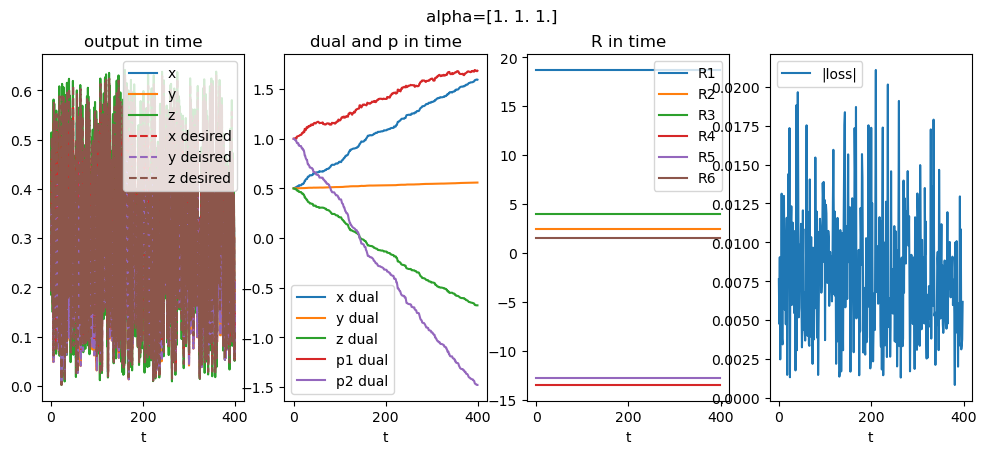

In [14]:
# Training + plot

state, variabs, desired = run_model_changing_alpha(alpha_vec, task_type, training, supress=False, bc_noise=0.0)

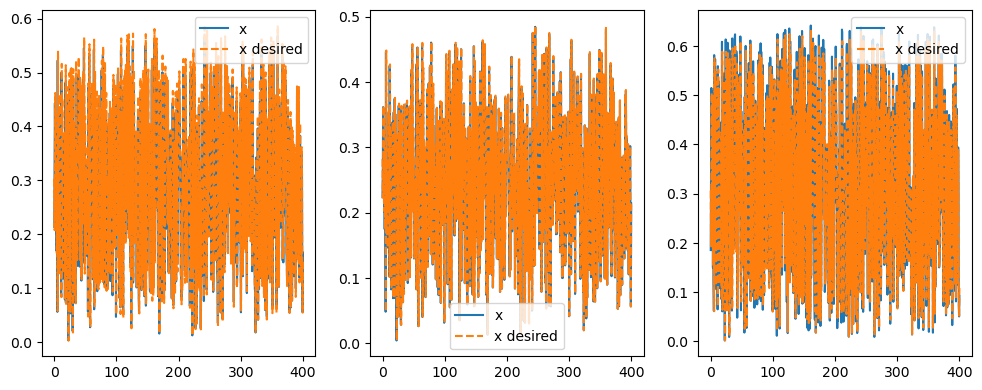

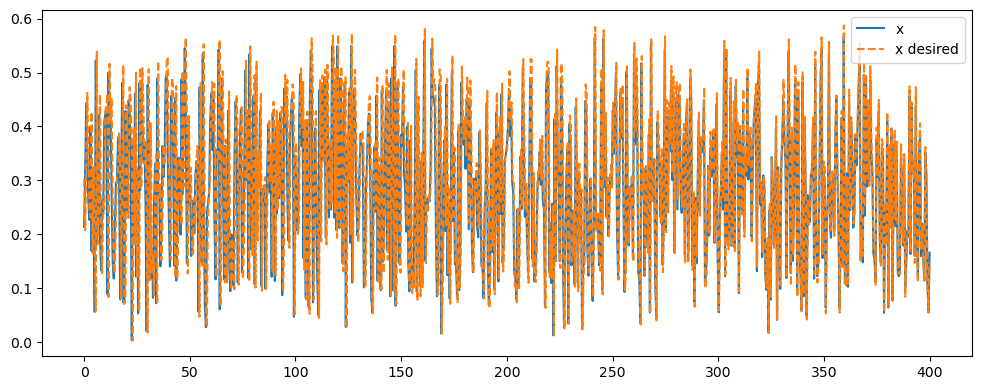

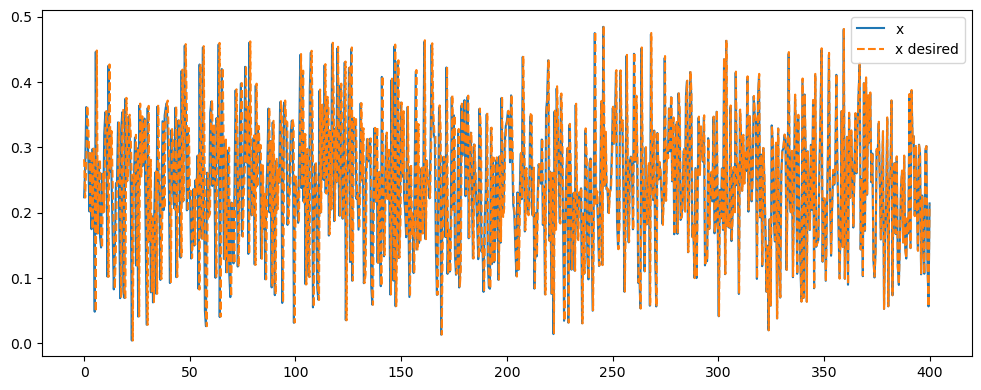

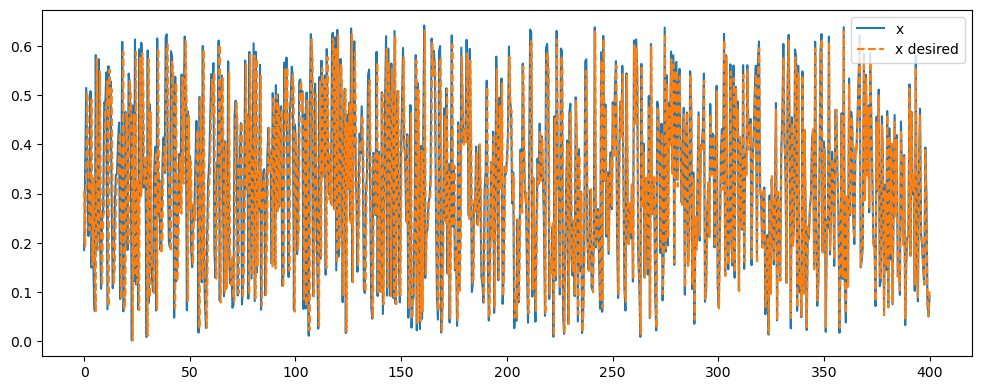

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4.5))
legend1 = ['x', 'x desired']
if variabs.task_type=='Allostery' or variabs.task_type=='Regression':
    pass
elif task_type=='General_reg':  # regression goes only every two samples
    for i in range(3):
        axes[i].plot(np.linspace(0, state.t, 2*state.t-1).T, np.vstack(state.out_in_t)[1:,i])
        axes[i].plot(np.linspace(0, state.t, 2*state.t).T, np.vstack(state.desired_in_t)[:,i], '--')
        axes[i].legend(legend1)
        
for i in range(3):
    fig, axes = plt.subplots(1, 1, figsize=(12, 4.5))
    plt.plot(np.linspace(0, state.t, 2*state.t-1).T, np.vstack(state.out_in_t)[1:,i])
    plt.plot(np.linspace(0, state.t, 2*state.t).T, np.vstack(state.desired_in_t)[:,i], '--')
    plt.legend(legend1)

Text(0, 0.5, '$x,y$')

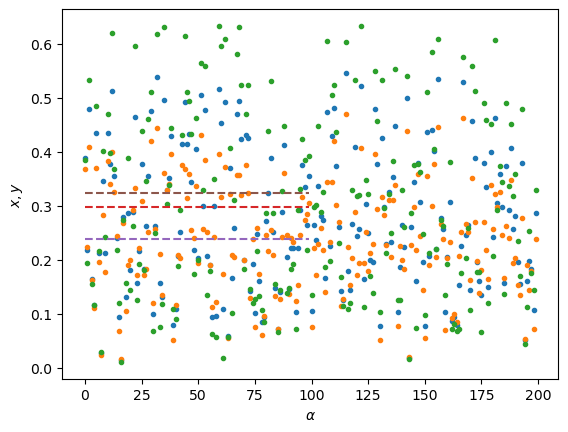

In [7]:
## plot the hysteresis curve
# it will work only if alpha is the same size as t

if len(alpha_vec.T) == len(state.out_in_t):
    plt.plot(alpha_vec.T, state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
    plt.xlim([min(alpha_vec[0])-0.01, max(alpha_vec[0]+0.01)])
else:
    plt.plot(state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$x,y$")

In [8]:
state.desired_in_t


[array([0.38882359, 0.36853582, 0.38930735]),
 array([0.21300614, 0.22320927, 0.2010899 ]),
 array([0.4940823 , 0.41028636, 0.52784906]),
 array([0.16290682, 0.16181912, 0.15887388]),
 array([0.11688442, 0.11079028, 0.11702722]),
 array([0.44823922, 0.37119701, 0.47945651]),
 array([0.21414028, 0.19603261, 0.21836922]),
 array([0.0275706 , 0.0236062 , 0.02904824]),
 array([0.36103569, 0.28532909, 0.3939813 ]),
 array([0.22057083, 0.17781013, 0.2387035 ]),
 array([0.44521175, 0.38404489, 0.4674439 ]),
 array([0.38427057, 0.34152605, 0.39771685]),
 array([0.54155217, 0.40345638, 0.60499113]),
 array([0.36014243, 0.32702394, 0.36877749]),
 array([0.23674529, 0.24490867, 0.22531636]),
 array([0.10115379, 0.06925566, 0.11649118]),
 array([0.01398294, 0.01695339, 0.01188603]),
 array([0.27922169, 0.26845253, 0.27739773]),
 array([0.1387386 , 0.10545339, 0.15379476]),
 array([0.31240218, 0.19270986, 0.37187201]),
 array([0.17273906, 0.19905814, 0.15276419]),
 array([0.2841986 , 0.29244868, 0.